# LAB 3 PART 2: Assignment 1

Author: Aliprandi Francesco

## Echo State Network

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/NARMA10.csv", header=None)
X, Y =  torch.tensor(df.iloc[0]),  torch.tensor(df.iloc[1])

X.shape, Y.shape

(torch.Size([10000]), torch.Size([10000]))

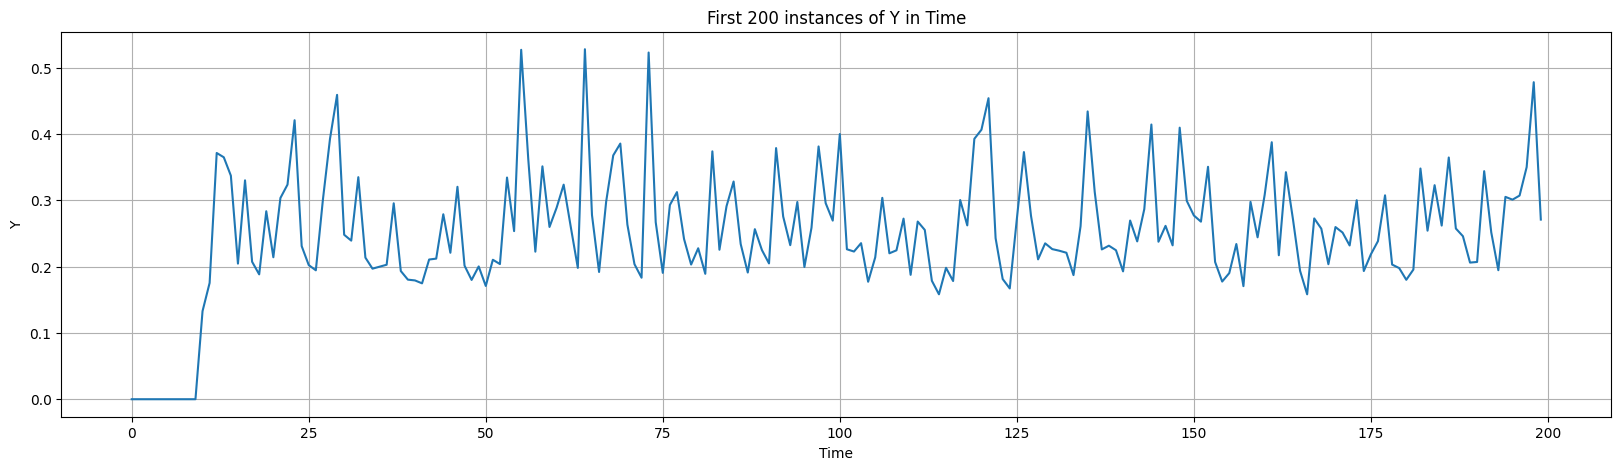

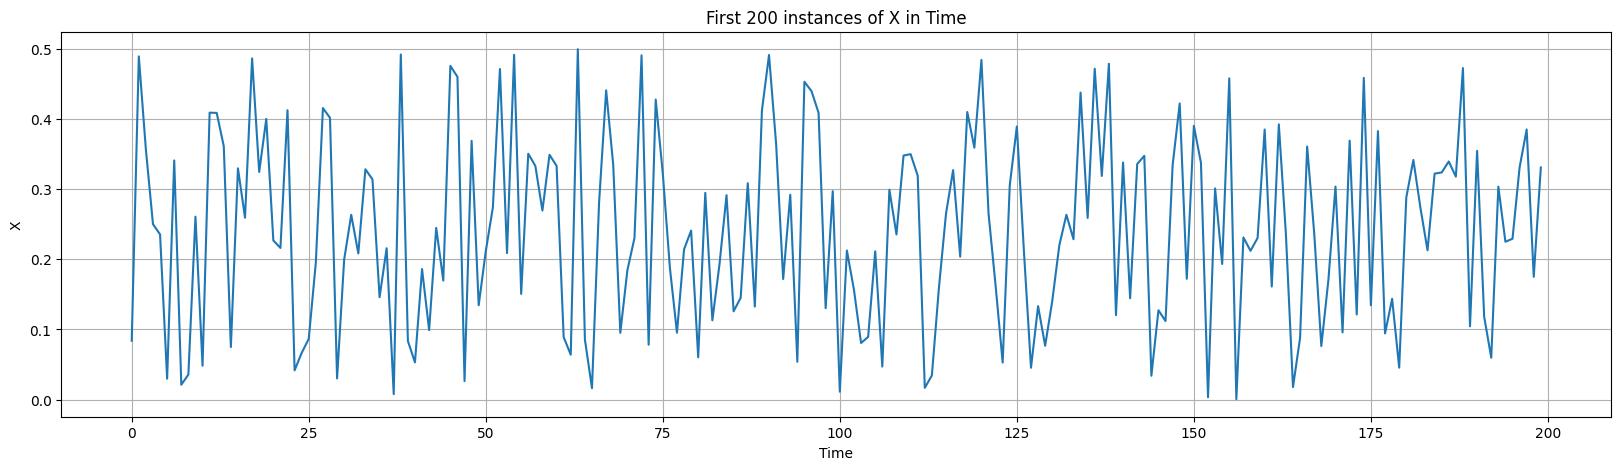

In [2]:
from utils import plot_time_series

time = torch.arange(0, X.shape[0])

plot_time_series(time, Y, "First 200 instances of Y in Time", "Time", "Y", 200)
plot_time_series(time, X, "First 200 instances of X in Time", "Time", "X", 200)
    

### Data Split

In [3]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(-1, 1).float()
x_val = x_val.reshape(-1, 1).float()
x_test = x_test.reshape(-1, 1).float()

y_train = y_train.reshape(-1, 1).float()
y_val = y_val.reshape(-1, 1).float()
y_test = y_test.reshape(-1, 1).float()
    
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([4000, 1])
Validation set shape: torch.Size([1000, 1])
Test set shape: torch.Size([5000, 1])


### Model Selection

<b>note:</b> hyperparameters are available in grid_param/esn.yaml 

In [4]:
from utils import import_parameters
from learning import parallel_grid_search

config = import_parameters("esn.yaml")

best_model, train_loss, val_loss, best_params = parallel_grid_search(
    random_iter=500,
    n_iter=5,
    config=config,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    seed=42,
)

ESN Grid Search: 100%|██████████| 500/500 [13:23<00:00,  1.61s/it]


Best validation loss: (0.0002016832906519994, 7.643197351878354e-06)


In [5]:
print("Best Parameters:")
for key, value in best_params.items():
    print(f" {key}: {value}")

Best Parameters:
 hidden_dim: 1024
 lambd: 0
 rho: 0.99
 omega_in: 25
 omega_bias: 25
 scaling_type: norm
 washout: 512


In [6]:

print(f"Training MSE: \t{train_loss[0]} +/- {train_loss[1]}")
print(f"Validation MSE:\t{val_loss[0]} +/- {val_loss[1]}")

Training MSE: 	0.0001939212583238259 +/- 2.989624729646937e-05
Validation MSE:	0.0002016832906519994 +/- 7.643197351878354e-06


### Model Retraining

In [13]:
x_retrain = torch.cat((x_train, x_val), dim=0)
y_retrain = torch.cat((y_train, y_val), dim=0)

for i in range(5):
    retraining_loss = []
    test_loss = []
    
    best_model.fit(
        x_train = x_train,
        y_train = y_train,
        lambd=best_params['lambd'],
    )    
    
    y_train_pred = best_model.forward(x_retrain)
    y_test_pred = best_model.forward(x_test)
    retraining_loss.append(best_model.loss(y_retrain, y_train_pred).item())
    test_loss.append(best_model.loss(y_test, y_test_pred).item())
    


#### Target vs Output signal for retraining and test set

Retraining MSE:  0.0001698757114354521 +/- 0.0
Test MSE: 	0.0001313442480750382 +/- 0.0


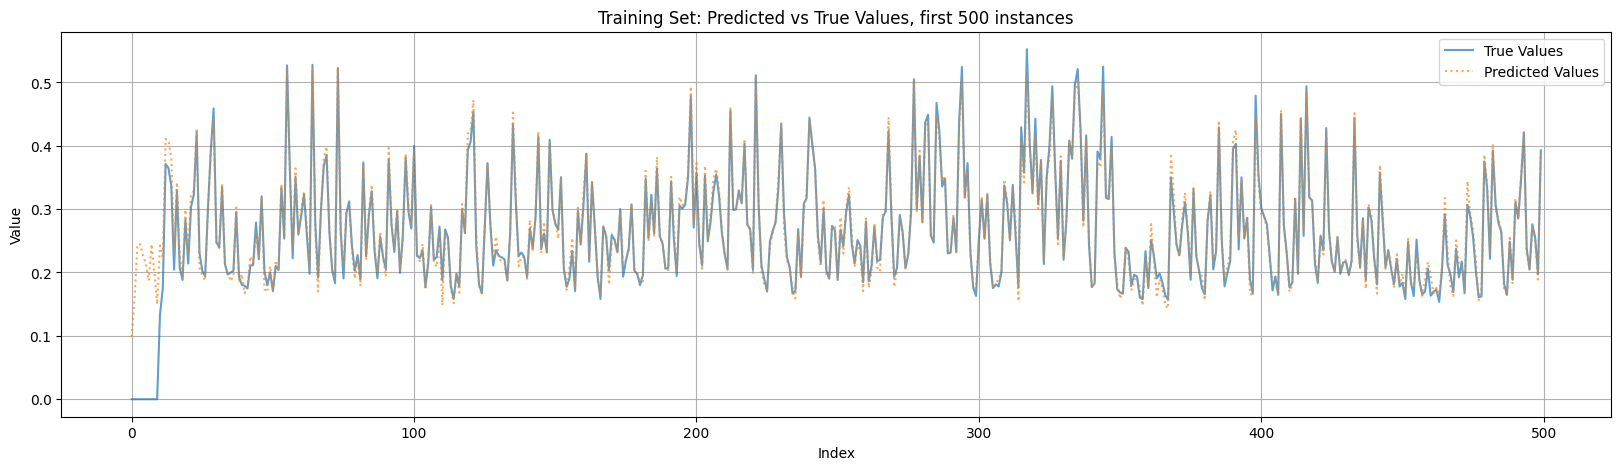

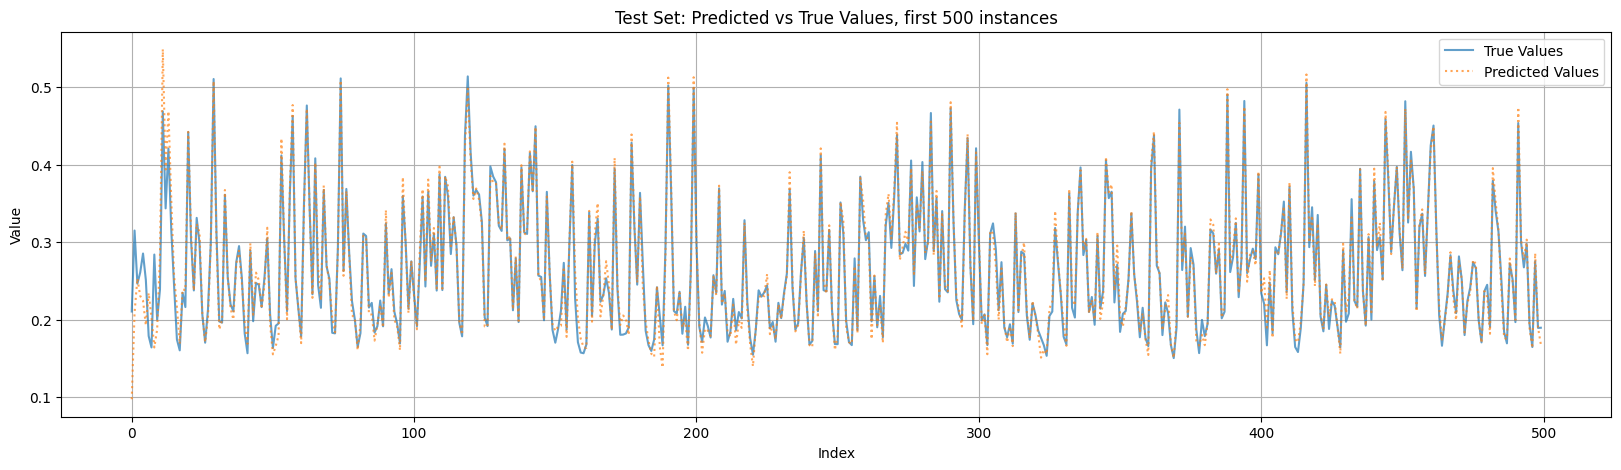

In [14]:
from utils import plot_predictions
import numpy as np

print(f"Retraining MSE:  {np.mean(retraining_loss)} +/- {np.std(retraining_loss)}")
print(f"Test MSE: \t{np.mean(test_loss)} +/- {np.std(test_loss)}")

n = 500


plot_predictions(y_retrain, y_train_pred, "Training Set: Predicted vs True Values, first " + str(n) +" instances", 0, n)

plot_predictions(y_test, y_test_pred, "Test Set: Predicted vs True Values, first " + str(n) +" instances", 0, n)





#### Storing best model parameters after retraining

In [ ]:
torch.set_printoptions(threshold=torch.inf)

out_file = "results/best_model_params.txt"

with open(out_file, "w") as f:
    f.write(f"--- Model Loss ---\n\n\n")
    f.write(f"Training MSE: \t{train_loss[0]} +/- {train_loss[1]}\n\n")
    f.write(f"Validation MSE:\t{val_loss[0]} +/- {val_loss[1]}\n\n")
    f.write(f"Retraining MSE:  {np.mean(retraining_loss)} +/- {np.std(retraining_loss)}\n\n")
    f.write(f"Test MSE: \t{np.mean(test_loss)} +/- {np.std(test_loss)}\n\n")

    parameters = best_model.get_parameters()
    f.write(f"--- Best Model Parameters ---\n\n\n")

    for key, value in parameters.items():
        f.write(f"{key}: {value}\n\n")
    
    f.write(f"---Best Model Hyperparameters ---\n\n\n")
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n\n")
